# Adaptive PDE discretizations on cartesian grids

## Part : Additional tools
## Chapter : Non rectangular domains

This notebook illustrates the implementation of monotone schemes on non-rectangular domains, with Dirichlet boundary conditions. We show how to describe the domain, and adapt the finite differences.

In [4]:
import sys; sys.path.append("../..") # Allow imports from parent directory
from Miscellaneous import TocTools; TocTools.displayTOC('Domains','NonDiv')

[**Summary**](Summary.ipynb) of this series of notebooks. 

[**Main summary**](../Summary.ipynb), including the other volumes of this work. 


# Table of contents

  * [1. Domain union, intersection](#1.-Domain-union,-intersection)




**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay


## 0. Import the required libraries

In [144]:
from NumericalSchemes import Domain
from NumericalSchemes import AutomaticDifferentiation as ad
from NumericalSchemes import FiniteDifferences as fd

In [145]:
import scipy.linalg
import numpy as np
from matplotlib import pyplot as plt

In [202]:
import importlib
Domain = importlib.reload(Domain)
ad.reload_submodules()

## 1. Geometric methods

### 1.1 Base domains, union, intersection, complement

Define a ball and a box domain.

In [203]:
ball = Domain.Ball(np.array([0,0]))
box = Domain.Box([[0,1],[0,1]])

Their intersection and relative complement.

In [204]:
cap = Domain.Intersection( (ball,box) )
compl = Domain.Complement(ball,box)

Their union. It turns out that the common boundaries smoothly align.

In [205]:
cup = Domain.Union((ball,box),smooth=True)

In [200]:
doms = (ball,box,cap,compl,cup)
domNames = ("ball","box","cap","compl","cup")

Let us display the domains.

In [114]:
aX=np.linspace(-1.2,1.2)
X = np.array(np.meshgrid(aX,aX,indexing='ij'))

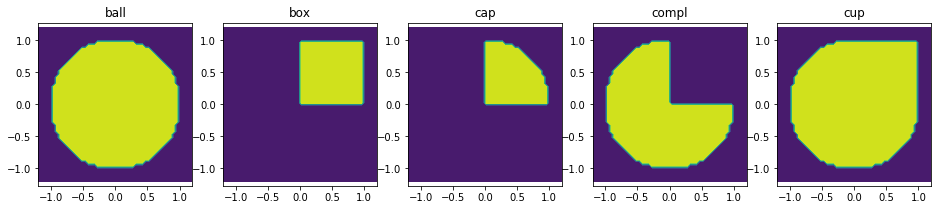

In [115]:
plt.figure(figsize=(16,3))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(1,5,1+i)
    plt.contourf(*X,dom.contains(X))
    plt.title(name)
    plt.axis('equal')

### 1.2 Level set and distance functions

Each domain comes equipped with a level set function, that is negative inside, and positive outside.

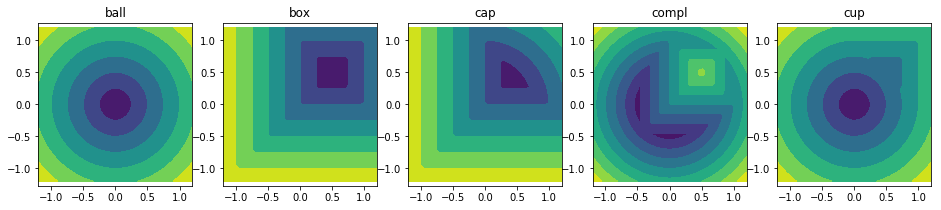

In [117]:
plt.figure(figsize=(16,3))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(1,5,1+i)
    plt.contourf(*X,dom.level(X))
    plt.title(name)
    plt.axis('equal')

The level set function is not the same as the distance function, whose computation may be more expensive, or may not be implemented in some regions. 
If you absolutely need a distance function, you may need to consider solving an eikonal equation, using a different domain representation, or using an adequate computational geometry package.

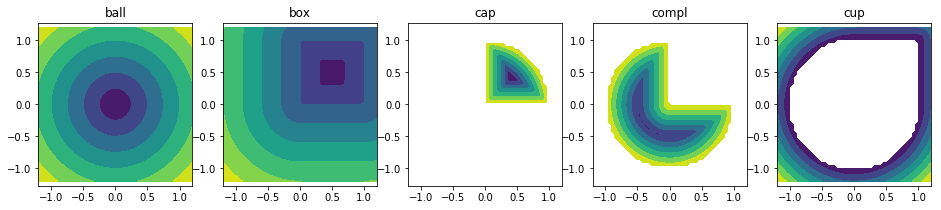

In [118]:
plt.figure(figsize=(16,3))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(1,5,1+i)
    plt.contourf(*X,dom.distance(X))
    plt.title(name)
    plt.axis('equal')

When the distance is available, a unit normal vector may be computed using automatic differentiation.

In [134]:
X_ad = ad.Dense.identity(constant=X,shape_free=(2,))
dist_ad = box.distance(X_ad)

../../NumericalSchemes/AutomaticDifferentiation/misc.py:219: RuntimeWarning: divide by zero encountered in power
  def pow1(x,n):	return (x**n,n*x**(n-1))
../../NumericalSchemes/AutomaticDifferentiation/Dense.py:85: RuntimeWarning: invalid value encountered in multiply
  return denseAD(a,_add_dim(b)*self.coef)


In [132]:
ad.Optimization.norm(dist_ad.coef,axis=2)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

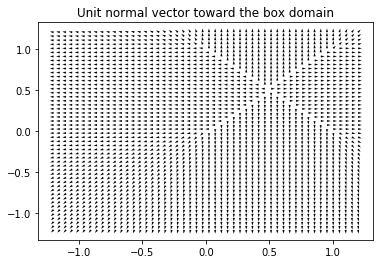

In [135]:
plt.title("Unit normal vector toward the box domain")
plt.quiver(*X,dist_ad.coef[:,:,0],dist_ad.coef[:,:,1]);

### 1.3 Distance to the boundary in a given direction.

For the design of finite difference schemes, it is important to know the distance from a given point to the domain boundary in a given direction. This is referred to as the "free way" from $x$ in the direction $v$.

In [206]:
v = np.array([1.,0.5])
V = fd.as_field(v,X.shape[1:])

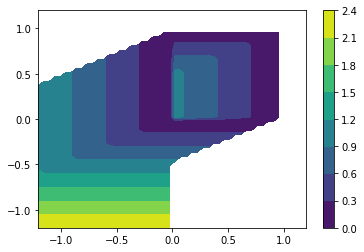

In [207]:
plt.contourf(*X,box.freeway(X,V)); plt.colorbar();